In [13]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import geopandas as gpd

### processing the two dataframes

In [15]:
new = pd.read_csv("./data/ag2016_2022_icrisat_harmonized.csv").iloc[:, 1:]
new = new.rename(columns={'ag_hy_crop': 'crop'}).drop(columns='Dist_Name')
new.loc[new['n_hybrid']==1, "match"] = "identical"
new.loc[new['n_hybrid']>1, "match"] = "mixed"
new['year'] = pd.to_numeric(new['year'])

zero_condition = (new['area_harvested'] == 0) & (new['production'] == 0) & (new['yield'] == 0)
new.loc[zero_condition, ['area_harvested', 'production', 'yield']] = np.nan

In [16]:
df = pd.read_csv("./IND/icrisat_apportioned/ICRISAT-District Level Data_Apportioned.csv")
df.loc[(df['State Name']=="Uttar Pradesh") & (df['Dist Name']== "Saharanpur"), "State Name"] = "Uttaranchal"
df = df.rename(columns={'Dist Name': 'Name_12', 'State Name': 'NAME_1'}).drop(columns={'Dist Code', 'State Code'})

df= pd.melt(df, id_vars=["Year", "NAME_1", "Name_12"], var_name= "var", value_name = "value" )
df[['crop', 'variable']] = df['var'].str.extract(r'^(.*?)\s(AREA|PRODUCTION|YIELD)', expand=True)
df = df.drop(columns='var')
df['crop'] = df['crop'].str.capitalize()
df['variable'] = df['variable'].str.lower()
df = df.pivot(index=["Year", "NAME_1", "Name_12", "crop"], columns= "variable", values="value" ).reset_index().rename_axis(None,axis=1)
df = df.rename(columns={"Year": 'year', 'area': "area_harvested"})
df['match'] = "original"
df['year'] = pd.to_numeric(df['year'])
df['yield']= df['yield']/1000

zero_condition = (df['area_harvested'] == 0) & (df['production'] == 0) & (df['yield'] == 0)
df.loc[zero_condition, ['area_harvested', 'production', 'yield']] = np.nan

In [17]:
#compare = oldcrops.merge(newcrops, indicator=True, how='outer')
#newcrops= new[['crop']].drop_duplicates().sort_values(by='crop')
#newcrops.to_csv("./data/cropkey_edit_in_excel.csv")
key = pd.read_csv("./data/cropkey.csv").dropna(subset='crop')
crop_mapping = dict(zip(key['crop'], key['ag_hy_crop']))
df['crop'] = df['crop'].replace(crop_mapping)

In [18]:
np.unique(df['crop'])

array(['Arhar/Tur', 'Bajra', 'Barley', 'Castor seed', 'Cotton(lint)',
       'Fruits', 'Fruits and vegetables', 'Gram', 'Groundnut',
       'Horse-gram', 'Kharif sorghum', 'Linseed', 'Maize', 'Minor pulses',
       'Oilseeds', 'Onion', 'Potatoes', 'Rabi sorghum', 'Ragi',
       'Rapeseed and mustard', 'Rice', 'Safflower', 'Sesamum', 'Sorghum',
       'Soyabean', 'Sugarcane', 'Sunflower', 'Vegetables', 'Wheat'],
      dtype=object)

### comparing 2016 and 2017

In [19]:
y16_harv = new[new['year']==2016]
y17_harv = new[new['year']==2017]
y16_icri = df[df['year']==2016]
y17_icri = df[df['year']==2017]

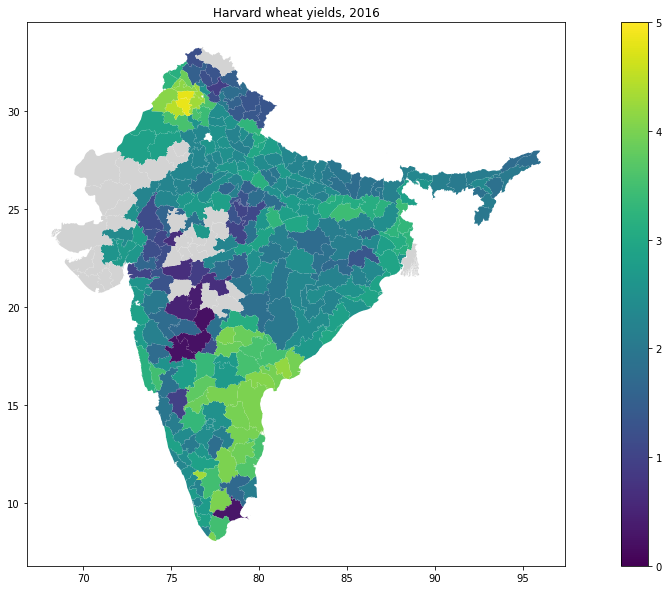

In [20]:
shp_path = "./IND/icrisat_apportioned/icrisat_boundary_match.shp"
icri = gpd.read_file(shp_path)[['NAME_1', "Name_12", "geometry"]]

test = y16_harv[y16_harv['crop']=="Rice"]
test = gpd.GeoDataFrame(icri.merge(test, how="left"))

fig, ax = plt.subplots(figsize=(20, 10))
test.plot(ax=ax, column="yield", vmin=0, vmax=5, legend=True, 
         missing_kwds=dict(color="lightgray"))
plt.title("Harvard wheat yields, 2016")
plt.savefig("./plots/rice16_harv.png")
plt.show()

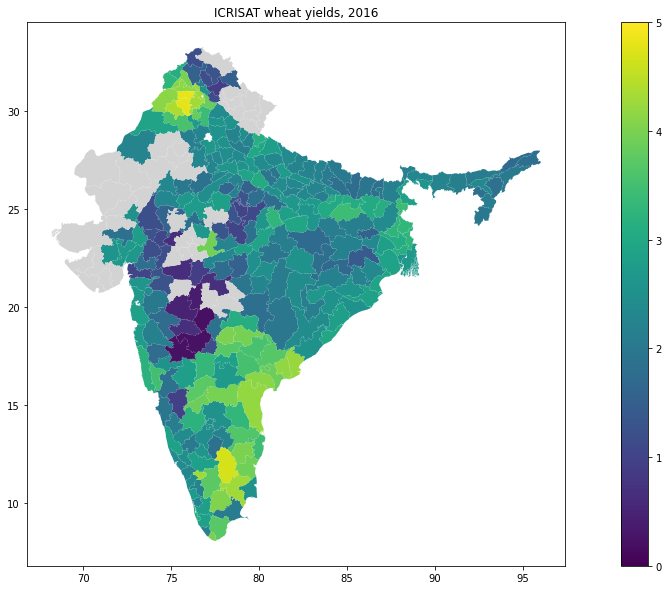

In [21]:
test = y16_icri[y16_icri['crop']=="Rice"]
test = gpd.GeoDataFrame(icri.merge(test, how="left"))

fig, ax = plt.subplots(figsize=(20, 10))
test.plot(ax=ax, column="yield", vmin=0, vmax=5, legend=True, 
         missing_kwds=dict(color="lightgray"))
plt.title("ICRISAT wheat yields, 2016")
plt.savefig("./plots/rice16_icri.png")
plt.show()

In [22]:
comp16= pd.merge(y16_harv, y16_icri, on=['NAME_1', 'Name_12', 'year', 'crop'], suffixes=('_harv', '_icri'))
comp17= pd.merge(y17_harv, y17_icri, on=['NAME_1', 'Name_12', 'year', 'crop'], suffixes=('_harv', '_icri'))

In [23]:
comp16['area_harvested_diff'] = (comp16['area_harvested_harv'] - comp16['area_harvested_icri']) / ((comp16['area_harvested_harv'] + comp16['area_harvested_icri'])/2) * 100
comp16['production_diff'] = (comp16['production_harv'] - comp16['production_icri']) / ((comp16['production_harv'] + comp16['production_icri'])/2) * 100
comp16['yield_diff'] = (comp16['yield_harv'] - comp16['yield_icri']) / ((comp16['yield_harv'] + comp16['yield_icri'])/2) *100

In [24]:
comp17['area_harvested_diff'] = (comp17['area_harvested_harv'] - comp17['area_harvested_icri']) / ((comp17['area_harvested_harv'] + comp17['area_harvested_icri'])/2) * 100
comp17['production_diff'] = (comp17['production_harv'] - comp17['production_icri']) / ((comp17['production_harv'] + comp17['production_icri'])/2) * 100
comp17['yield_diff'] = (comp17['yield_harv'] - comp17['yield_icri']) / ((comp17['yield_harv'] + comp17['yield_icri'])/2)* 100

<Figure size 720x432 with 0 Axes>

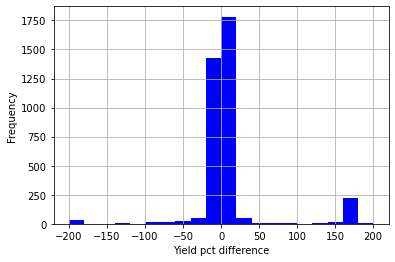

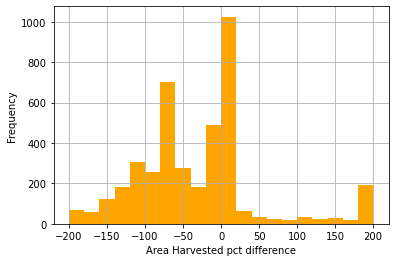

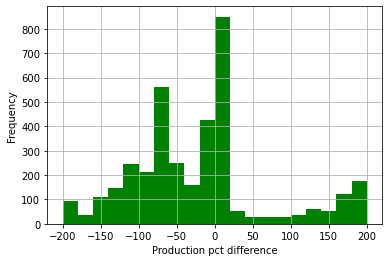

In [25]:
plt.figure(figsize=(10, 6))

plt.figure()
comp16['yield_diff'].hist(bins=20, color="blue")
plt.xlabel("Yield pct difference")
plt.ylabel("Frequency")
plt.show()

# Histogram 2: Area Harvested
plt.figure()
comp16['area_harvested_diff'].hist(bins=20, color="orange")
plt.xlabel("Area Harvested pct difference")
plt.ylabel("Frequency")
plt.show()

# Histogram 3: Production
plt.figure()
comp16['production_diff'].hist(bins=20, color='green')
plt.xlabel("Production pct difference")
plt.ylabel("Frequency")
plt.show()


<Figure size 720x432 with 0 Axes>

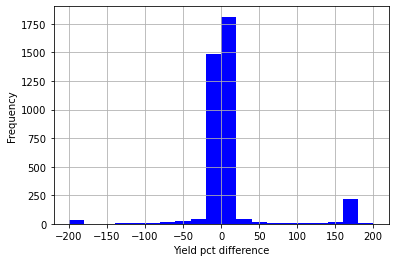

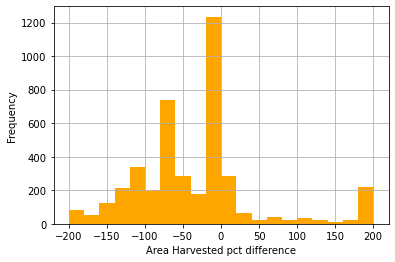

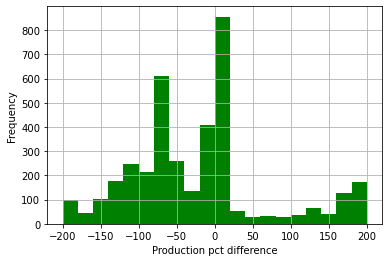

In [26]:
plt.figure(figsize=(10, 6))

plt.figure()
comp17['yield_diff'].hist(bins=20, color="blue")
plt.xlabel("Yield pct difference")
plt.ylabel("Frequency")
plt.show()

# Histogram 2: Area Harvested
plt.figure()
comp17['area_harvested_diff'].hist(bins=20, color="orange")
plt.xlabel("Area Harvested pct difference")
plt.ylabel("Frequency")
plt.show()

# Histogram 3: Production
plt.figure()
comp17['production_diff'].hist(bins=20, color='green')
plt.xlabel("Production pct difference")
plt.ylabel("Frequency")
plt.show()


In [27]:
comp16.loc[abs(comp16['yield_diff'])<1, "yield_alignment"] = "<1% diff"
comp16.loc[(abs(comp16['yield_diff']) > 1) & (abs(comp16['yield_diff']) <= 10), "yield_alignment"] = "1-10% diff"
comp16.loc[abs(comp16['yield_diff'])>10, "yield_alignment"] = ">10% diff"

In [28]:
comp17.loc[abs(comp17['yield_diff'])<1, "yield_alignment"] = "<1% diff"
comp17.loc[(abs(comp17['yield_diff']) > 1) & (abs(comp17['yield_diff']) <= 10), "yield_alignment"] = "1-10% diff"
comp17.loc[abs(comp17['yield_diff'])>10, "yield_alignment"] = ">10% diff"

In [29]:
merge16 = comp16[['NAME_1', 'Name_12', 'year', 'crop', 'yield_alignment']]
merge17 = comp17[['NAME_1', 'Name_12', 'year', 'crop', 'yield_alignment']]
tomerge = pd.concat([merge16, merge17])

### merging the two

In [89]:
full_ts = pd.concat([df, new])
full_ts

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/lib/pretty.py:700: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/formatters.py:345: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,year,NAME_1,Name_12,crop,area_harvested,production,yield,match,n_hybrid,seasons,duplicated
0,1966.0,Andhra Pradesh,Ananthapur,Barley,NaN,NaN,NaN,original,NaN,NaN,NaN
1,1966.0,Andhra Pradesh,Ananthapur,Castor seed,10.900000,2.100000,0.192660,original,NaN,NaN,NaN
2,1966.0,Andhra Pradesh,Ananthapur,Gram,2.000000,1.000000,0.500000,original,NaN,NaN,NaN
3,1966.0,Andhra Pradesh,Ananthapur,Cotton(lint),42.000000,2.000000,0.047620,original,NaN,NaN,NaN
4,1966.0,Andhra Pradesh,Ananthapur,Ragi,39.000000,29.000000,0.743590,original,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
56248,2022.0,West Bengal,West Dinajpur,Sesamum,0.430792,0.298417,0.692717,mixed,2.0,1.416667,False
56249,2022.0,West Bengal,West Dinajpur,Sugarcane,0.367417,30.495583,83.000000,mixed,2.0,1.000000,False
56250,2022.0,West Bengal,West Dinajpur,Sunflower,0.004000,0.003000,0.750000,identical,1.0,1.000000,False
56251,2022.0,West Bengal,West Dinajpur,Urad,1.134333,0.811708,0.715582,mixed,2.0,1.583333,False


In [92]:
full_ts['match'] = full_ts['match'].astype(str).str.strip() 

notavg = full_ts.groupby(['year', 'NAME_1', 'Name_12', 'crop', 'match'], as_index=False).agg({
    'area_harvested': 'mean',
    'production': 'mean',
    'yield': 'mean',
    'n_hybrid': 'mean'})

notavg.to_csv("./data/icrisat_1966_2022_1617NOTAVG.csv", index=False)

In [68]:
def unique_match(strings):
    strings = strings.dropna().astype(str)
    unique_values = sorted(strings.unique()) 
    return ', '.join(unique_values) if len(unique_values) > 1 else unique_values[0] if len(unique_values) == 1 else None

final = full_ts.groupby(['year', 'NAME_1', 'Name_12', 'crop'], as_index=False).agg({
    'area_harvested': 'mean',
    'production': 'mean',
    'yield': 'mean',
    'n_hybrid': 'mean',
    'seasons' : 'mean',
    'duplicated': unique_match,
    'match': unique_match  })

In [18]:
###new[(new['NAME_1']=="Uttar Pradesh") & (new['Name_12']=="Pilibhit") & (new['crop']=="Dry chillies")]

In [69]:
np.unique(final['match'])

array(['identical', 'identical, original', 'mixed', 'mixed, original',
       'original'], dtype=object)

In [79]:
final = final.rename(columns={'yield': 'yield_fake'})
final['yield'] = final['production']/final['area_harvested']

In [86]:
check= final['yield']- final['yield_fake']
check.describe()

count    2.893560e+05
mean              NaN
std               NaN
min              -inf
25%     -1.717172e-06
50%      0.000000e+00
75%      1.587302e-06
max               inf
dtype: float64

In [87]:
fin = final.drop(columns="yield_fake").merge(tomerge, how="left")
fin

,year,NAME_1,Name_12,crop,area_harvested,production,n_hybrid,seasons,duplicated,match,yield,yield_alignment
0,1966.0,Andhra Pradesh,Ananthapur,Arhar/Tur,29.000000,5.000000,NaN,NaN,None,original,0.172414,NaN
1,1966.0,Andhra Pradesh,Ananthapur,Bajra,106.000000,36.800000,NaN,NaN,None,original,0.347170,NaN
2,1966.0,Andhra Pradesh,Ananthapur,Barley,NaN,NaN,NaN,NaN,None,original,NaN,NaN
3,1966.0,Andhra Pradesh,Ananthapur,Castor seed,10.900000,2.100000,NaN,NaN,None,original,0.192661,NaN
4,1966.0,Andhra Pradesh,Ananthapur,Cotton(lint),42.000000,2.000000,NaN,NaN,None,original,0.047619,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
516016,2022.0,West Bengal,West Dinajpur,Sesamum,0.430792,0.298417,2.0,1.416667,False,mixed,0.692717,NaN
516017,2022.0,West Bengal,West Dinajpur,Sugarcane,0.367417,30.495583,2.0,1.000000,False,mixed,83.000000,NaN
516018,2022.0,West Bengal,West Dinajpur,Sunflower,0.004000,0.003000,1.0,1.000000,False,identical,0.750000,NaN
516019,2022.0,West Bengal,West Dinajpur,Urad,1.134333,0.811708,2.0,1.583333,False,mixed,0.715582,NaN


In [21]:
os.system('say "done"')

0

In [88]:
fin.to_csv("./data/icrisat_1966_2022.csv", index=False)